In [1]:
#import jax and other libraries for computation
import jax.numpy as jnp
from jax import jit
from jax.scipy.signal import convolve2d
from jax.flatten_util import ravel_pytree
from jax.experimental.ode import odeint
from jax import tree_util
import jax.random as random
import numpy as np
#for visulization
import os
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
# Set Palatino as the default font
font = {'family': 'serif', 'serif': ['Palatino'], 'size': 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)
# import AdoptODE
from adoptODE import train_adoptODE, simple_simulation, dataset_adoptODE
#import the MSD mechanics
from HelperAndMechanics import *
import h5py

In [2]:
# Load from HDF5
mode = 'chaos'
with h5py.File(f'../data/SpringMassModel/MechanicalData/data_eta_05_uvx_{mode}.h5', 'r') as f:
    v = f['v'][:1000]
    u = f['u'][:1000]
    T = f['T'][:1000]
    x = f['x'][:1000]
    f.close()

In [3]:
def define_MSD(**kwargs_sys):
    N_sys = kwargs_sys['N_sys']

    def gen_params():
        return {key:value + kwargs_sys['par_tol']*value*np.random.uniform(-1.0, 1.0) for key,value in kwargs_sys['params_true'].items()}, {}, {}
    
    def gen_y0():
        return {'u':kwargs_sys['u0'],'v':kwargs_sys['v0'],'T':kwargs_sys['T0'],'x':kwargs_sys['x0'],'x_dot':kwargs_sys['x_dot0']}
    @jit
    def kernel(params):
        spacing = params['spacing']
        kernel = params['D']*np.array([[1, 4, 1], [4, -20.0, 4], [1, 4, 1]]) / (spacing* spacing * 6)
        return kernel
    @jit
    def laplace(f,params):  #laplace of scalar
        f_ext = jnp.concatenate((f[0:1], f, f[-1:]), axis=0)
        f_ext = jnp.concatenate((f_ext[:, 0:1], f_ext, f_ext[:, -1:]), axis=1)
        return convolve2d(f_ext, kernel(params), mode='valid')
    @jit
    def rotate_diffusion_tensor(params):
        D1, D2 = params['D1'], params['D2']
        a = params['l_0']/2
        b = jnp.abs(params['l_0']/2-params['n_0'])
        c = jnp.sqrt(a**2 + b**2)
        cos_theta = a / c
        sin_theta = b / c

        # Compute the rotated diffusion tensor
        D11 = D1 * cos_theta**2 + D2 * sin_theta**2
        D12 = (D1 - D2) * cos_theta * sin_theta
        D22 = D1 * sin_theta**2 + D2 * cos_theta**2
        
        return D11, D22, D12, D12
    @jit
    def diffusion_kernel(params):
        """Constructs a 3x3 anisotropic diffusion kernel."""
        h = params['spacing']
        D_11,D_22,D_12,D_21 = rotate_diffusion_tensor(params)
        
        kernel = jnp.array([
            [ D_12 / (2 * h**2),  D_22 / h**2, -D_12 / (2 * h**2)],
            [ D_11 / h**2,  -2 * (D_11 + D_22) / h**2,  D_11 / h**2],
            [-D_12 / (2 * h**2),  D_22 / h**2,  D_12 / (2 * h**2)]
        ])
        return kernel
    @jit
    def epsilon(u,v,rp):
        return rp['epsilon_0']+rp['mu_1']*v/(u+rp['mu_2'])
    @jit
    def epsilon_T(u):
        return 1 - 0.9*jnp.exp(-jnp.exp(-30*(jnp.abs(u) - 0.1)))
    
    if kwargs_sys['eta_var'] == True: 
        @jit
        def eom(y, t, params, iparams, exparams):
                
                par=params
                u=y['u']
                v=y['v']
                T=y['T']
                x=y['x']
                x_dot=y['x_dot']

                dudt = laplace(u,par)-(par['k'])*u*(u-par['a'])*(u-1) - u*v
                dvdt = epsilon(u,v,par)*(-v-(par['k'])*u*(u-par['a']-1))
                dTdt = epsilon_T(u)*(par['k_T']*jnp.abs(u)-T)
                dx_dotdt = 1/par['m'] *  (force_field_active_n_var(x,T,par,kwargs_sys) + force_field_passive_n_var(x,par,kwargs_sys) + force_field_struct(x,T,par) - x_dot * par['c_damp'])
                dxdt = x_dot

                return {'u':dudt, 'v':dvdt, 'T':dTdt, 'x':zero_out_edges(dxdt), 'x_dot':zero_out_edges(dx_dotdt)}
    else:
        @jit
        def eom(y, t, params, iparams, exparams):
                
                par=params
                u=y['u']
                v=y['v']
                T=y['T']
                x=y['x']
                x_dot=y['x_dot']

                dudt = laplace(u,par)-(par['k'])*u*(u-par['a'])*(u-1) - u*v
                dvdt = epsilon(u,v,par)*(-v-(par['k'])*u*(u-par['a']-1))
                dTdt = epsilon_T(u)*(par['k_T']*jnp.abs(u)-T)
                dx_dotdt = 1/par['m'] *  (force_field_active(x,T,par) + force_field_passive(x,par) + force_field_struct(x,T,par) - x_dot * par['c_damp'])
                dxdt = x_dot

                return {'u':dudt, 'v':dvdt, 'T':dTdt, 'x':zero_out_edges(dxdt), 'x_dot':zero_out_edges(dx_dotdt)}
    @jit
    def loss(ys, params, iparams, exparams, targets):
        # u = ys['u']
        # u_target = targets['u']
        pad = 10
        x = ys['x'][:,:,pad:-pad,pad:-pad]
        x_target = targets['x'][:,:,pad:-pad,pad:-pad]
        x_dot = ys['x_dot'][:,:,pad:-pad,pad:-pad]
        x_dot_target = targets['x_dot'][:,:,pad:-pad,pad:-pad]
        
        return  jnp.nanmean((x - x_target)**2 + (x_dot-x_dot_target)**2)#jnp.nanmean((u - u_target)**2) +
            
    return eom, loss, gen_params, gen_y0, {}

def define_MSD_rec(**kwargs_sys):
    N_sys = kwargs_sys['N_sys']

    def gen_params():
        return {key:value + kwargs_sys['par_tol']*value*np.random.uniform(-1.0, 1.0) for key,value in kwargs_sys['params_true'].items()}, {}, {}
    
    def gen_y0():
        return {'u':kwargs_sys['u0'],'v':kwargs_sys['v0'],'T':kwargs_sys['T0'],'x':kwargs_sys['x0'],'x_dot':kwargs_sys['x_dot0']}
    @jit
    def kernel(params):
        spacing = params['spacing']
        kernel = params['D']*np.array([[1, 4, 1], [4, -20.0, 4], [1, 4, 1]]) / (spacing* spacing * 6)
        return kernel
    @jit
    def laplace(f,params):  #laplace of scalar
        f_ext = jnp.concatenate((f[0:1], f, f[-1:]), axis=0)
        f_ext = jnp.concatenate((f_ext[:, 0:1], f_ext, f_ext[:, -1:]), axis=1)
        return convolve2d(f_ext, kernel(params), mode='valid')
    @jit
    def rotate_diffusion_tensor(params):
        D1, D2 = params['D1'], params['D2']
        a = params['l_0']/2
        b = jnp.abs(params['l_0']/2-params['n_0'])
        c = jnp.sqrt(a**2 + b**2)
        cos_theta = a / c
        sin_theta = b / c

        # Compute the rotated diffusion tensor
        D11 = D1 * cos_theta**2 + D2 * sin_theta**2
        D12 = (D1 - D2) * cos_theta * sin_theta
        D22 = D1 * sin_theta**2 + D2 * cos_theta**2
        
        return D11, D22, D12, D12
    @jit
    def diffusion_kernel(params):
        """Constructs a 3x3 anisotropic diffusion kernel."""
        h = params['spacing']
        D_11,D_22,D_12,D_21 = rotate_diffusion_tensor(params)
        
        kernel = jnp.array([
            [ D_12 / (2 * h**2),  D_22 / h**2, -D_12 / (2 * h**2)],
            [ D_11 / h**2,  -2 * (D_11 + D_22) / h**2,  D_11 / h**2],
            [-D_12 / (2 * h**2),  D_22 / h**2,  D_12 / (2 * h**2)]
        ])
        return kernel
    @jit
    def epsilon(u,v,rp):
        return rp['epsilon_0']+rp['mu_1']*v/(u+rp['mu_2'])
    @jit
    def epsilon_T(u):
        return 1 - 0.9*jnp.exp(-jnp.exp(-30*(jnp.abs(u) - 0.1)))
    
    if kwargs_sys['eta_var'] == True: 
        @jit
        def eom(y, t, params, iparams, exparams):
                par=params
                u=y['u']
                v=y['v']
                T=y['T']
                x=y['x']
                x_dot=y['x_dot']

                dudt = laplace(u,par)-(par['k'])*u*(u-par['a'])*(u-1) - u*v
                dvdt = epsilon(u,v,par)*(-v-(par['k'])*u*(u-par['a']-1))
                dTdt = epsilon_T(u)*(par['k_T']*jnp.abs(u)-T)
                dx_dotdt = 1/par['m'] *  (force_field_active_n_var_rec(x,T,par,kwargs_sys['n_gaussians']) + force_field_passive_n_var_rec(x,par,kwargs_sys['n_gaussians']) + force_field_struct(x,T,par) - x_dot * par['c_damp'])
                dxdt = x_dot

                return {'u':dudt, 'v':dvdt, 'T':dTdt, 'x':zero_out_edges(dxdt), 'x_dot':zero_out_edges(dx_dotdt)}
    else:
        @jit
        def eom(y, t, params, iparams, exparams):
                par=params
                u=y['u']
                v=y['v']
                T=y['T']
                x=y['x']
                x_dot=y['x_dot']

                dudt = laplace(u,par)-(par['k'])*u*(u-par['a'])*(u-1) - u*v
                dvdt = epsilon(u,v,par)*(-v-(par['k'])*u*(u-par['a']-1))
                dTdt = epsilon_T(u)*(par['k_T']*jnp.abs(u)-T)
                dx_dotdt = 1/par['m'] *  (force_field_active(x,T,par) + force_field_passive(x,par) + force_field_struct(x,T,par) - x_dot * par['c_damp'])
                dxdt = x_dot

                return {'u':dudt, 'v':dvdt, 'T':dTdt, 'x':zero_out_edges(dxdt), 'x_dot':zero_out_edges(dx_dotdt)}
    
    @jit
    def loss(ys, params, iparams, exparams, targets):
        # u = ys['u']
        # u_target = targets['u']
        pad = 10
        x = ys['x'][:,:,pad:-pad,pad:-pad]
        x_target = targets['x'][:,:,pad:-pad,pad:-pad]
        x_dot = ys['x_dot'][:,:,pad:-pad,pad:-pad]
        x_dot_target = targets['x_dot'][:,:,pad:-pad,pad:-pad]
        u_target = targets['u']
        u = ys['u']
        dA = compute_dA(x,1)
        dA_target = compute_dA(x_target,1)
        return  jnp.nanmean((dA-dA_target)**2)  #+ jnp.nanmean((u - u_target)**2)#jnp.nanmean((x - x_target)**2 + (x_dot-x_dot_target)**2)#
            
    return eom, loss, gen_params, None, {}

def compute_log_div(data):
    """
    Compute the largest Lyapunov exponent from reaction-diffusion system data.
    
    Parameters:
    data (numpy.ndarray): 3D array of shape (t, 100, 100), where t is time.
    
    Returns:
    float: Estimated largest Lyapunov exponent (lambda_max).
    """
    t, x, y = data.shape  # Extract dimensions
    states = data.reshape(t, -1)  # Flatten spatial dimensions
    
    # Compute Euclidean distances between consecutive states
    distances = np.linalg.norm(states[1:] - states[:-1], axis=1)
    
    # Avoid division by zero
    if distances[0] == 0:
        raise ValueError("Initial distance is zero; choose different initial conditions.")
    
    # Compute log divergence over time
    log_divergence = np.log(distances / distances[0])
    
    return log_divergence  # Largest Lyapunov exponent

def expand_dict_arrays(data_dict, N_sys):
    """
    Expands each array in the dictionary along the first axis to shape (N_sys, ...).
    
    Parameters:
    - data_dict (dict): Dictionary with arrays of shape (1, ...)
    - N_sys (int): Number of copies along the first axis

    Returns:
    - expanded_dict (dict): Dictionary with arrays of shape (N_sys, ...)
    """
    return {key: np.tile(arr, (N_sys, *[1] * (arr.ndim - 1))) for key, arr in data_dict.items()}


In [4]:
@jit
def get_n_dist(n_dict,params):
    filtered_keys = n_dict.keys()
    
    indices = jnp.array([(int(k[1:3]), int(k[3:5])) for k in filtered_keys])
    values = jnp.array([params[k] for k in filtered_keys])

    # Initialize an empty JAX array
    n_distr_reconstructed = jnp.zeros((100, 100))

    # Populate the array using indexed assignment
    n_distr_reconstructed = n_distr_reconstructed.at[indices[:, 0], indices[:, 1]].set(values)
    return n_distr_reconstructed

In [5]:
"""
    Reads in necessary parameters from config.ini
"""
N,size,params = read_config(['D','a','k','epsilon_0','mu_1','mu_2','k_T','delta_t_e'
                             ,'k_T','k_ij','k_ij_pad','k_j','k_a','k_a_pad','c_a','m','c_damp',
                             'n_0','l_0','spacing'],mode = mode)
keys =['D','a','k','epsilon_0','mu_1','mu_2','k_T','delta_t_e'
        ,'k_T','k_ij','k_ij_pad','k_j','k_a','k_a_pad','c_a','m','c_damp',
        'n_0','l_0','spacing']
n_dist = np.load('../data/SpringMassModel/FiberOrientation/fiber_orientation.npy')
tol = 0

params_true = dict(zip(keys,params))
params_true['D1'] = params_true['D'] *1/3
params_true['D2'] = params_true['D'] 
params_low = {key: value - value*tol for key, value in params_true.items()}
params_high = {key: value + value*tol for key, value in params_true.items()}
print(params_true)
x_dot = np.gradient(x, axis=0) / params_true['delta_t_e']

length,sampling_rate = 15,15
pad = 10
u0,v0,T0,x0,x_dot0,t_evals = u[0],v[0],T[0],x[0],x_dot[0],np.linspace(0, params_true['delta_t_e']*sampling_rate*length, length)
print(n_dist.shape)
kwargs_sys = {'size': 100,
              'spacing': 1,
              'N_sys': 1,
              'par_tol': 0,
              'n_dist': n_dist,
              'eta_var': False,
              'mode': mode,
              'params_true': params_true,
              'u0': u0,'v0': v0,'T0': T0,'x0': x0,'x_dot0': x_dot0}
kwargs_adoptODE = {'epochs': 10,'lr':2e-3}

{'D': 0.22, 'a': 0.05, 'k': 8.0, 'epsilon_0': 0.002, 'mu_1': 0.2, 'mu_2': 0.3, 'k_T': 3.0, 'delta_t_e': 0.08, 'k_ij': 13.0, 'k_ij_pad': 23.0, 'k_j': 2.0, 'k_a': 9.0, 'k_a_pad': 23.0, 'c_a': 10.0, 'm': 1.0, 'c_damp': 15.0, 'n_0': 0.5, 'l_0': 1.0, 'spacing': 1.0, 'D1': 0.07333333333333333, 'D2': 0.22}
(100, 100)


In [6]:
Simulation_MSD = simple_simulation(define_MSD,
                                t_evals,
                                kwargs_sys,
                                kwargs_adoptODE)

2025-06-05 09:59:26.505254: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[1,1,100,100]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,1,102,102]{3,2,1,0}, f32[1,1,3,3]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-06-05 09:59:29.503701: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 3.998844085s
Trying algorithm eng0{} for conv (f32[1,1,100,100]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,1,102,102]{3,2,1,0}, f32[1,1,3,3]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_resul

In [8]:
u_sim = Simulation_MSD.ys['u'][0]
x_sim = Simulation_MSD.ys['x'][0]
x_dot_sim = Simulation_MSD.ys['x_dot'][0]
v_sim = Simulation_MSD.ys['v'][0]
T_sim = Simulation_MSD.ys['T'][0]
dA_sim = compute_dA(x_sim, 1)[:,pad:-pad,pad:-pad]
dA = compute_dA(x, 1)
 
vmin,vmax = 0,1
pad = 10

# Function to update the plot

def update_plot(frame):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))  # Create 2 side-by-side subplots
    
    # Plot dA_fit
    im1 = axes[0].matshow(dA[fr,pad:-pad,pad:-pad],cmap='coolwarm',vmin=vmin, vmax=vmax)
    # im1 = axes[0].matshow(dA_rec[frame, pad:-pad, pad:-pad], cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[0].set_title(f"data")
    
    # Plot dA_sim
    im2 = axes[1].matshow(dA_sim[frame,pad:-pad,pad:-pad], cmap='coolwarm',vmin=vmin, vmax=vmax)
    # im2 = axes[1].matshow(dA_sim[frame, pad:-pad, pad:-pad], cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[1].set_title(f"Sim")
    
    # Add colorbars
    fig.colorbar(im1, ax=axes[0])
    fig.colorbar(im2, ax=axes[1])

    plt.show()
def update_single_plot(frame):
    fig,axes = plt.subplots(1, 1, figsize=(10,8))

    # Plot dA_fit
    im1 = axes.matshow(u_sim[frame], cmap='coolwarm', vmin=vmin, vmax=vmax)
    # im1 = axes.matshow(dA_err[frame, pad:-pad, pad:-pad], cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes.set_title(f"u")

    # Add colorbars
    fig.colorbar(im1, ax=axes)

    plt.show()

# # Create interactive slider
# frame_slider = widgets.IntSlider(min=0, max=dA_sim.shape[0]-1, step=1, value=0, description="Frame")

# # Use interactive_output instead of interactive
# out = widgets.interactive_output(update_single_plot, {'frame': frame_slider})

# # # Display slider and output
# display(frame_slider, out)



import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import ipywidgets as widgets
def plot_AP_interactive(t):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # 2D heatmap of u at time t
    im = axs[0].imshow(u_sim[t], cmap='viridis')
    axs[0].set_title(f'u')
    axs[0].plot(70, 60, 'ro')  # mark the (50,60) point
    plt.colorbar(im, ax=axs[0])

    # Line plot at x=60 (column), over y=0..99
    axs[1].scatter(t,u_sim[t, 70, 60]/np.max(u_sim), color='black')
    axs[1].plot(u_sim[:,70,60]/np.max(u_sim), label='u')
    axs[1].scatter(t,v_sim[t, 70, 60]/np.max(v_sim), color='black')
    axs[1].plot(v_sim[:,70,60]/np.max(v_sim), label='v')
    axs[1].set_title(f'Vertical slice ')
    axs[1].set_xlabel('t in a.u.')
    axs[1].set_ylabel('Value')
    axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

# interact(plot_AP_interactive, t=IntSlider(min=0, max=u_sim.shape[0]-1, step=1, value=0));

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter

# --- Create the figure and subplots ---
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# --- Initialize plots ---
im = axs[0].imshow(np.zeros_like(u_sim[0]), cmap='coolwarm')
point = axs[0].plot(78, 68, 'ro',color ='black')[0]
cbar = plt.colorbar(im, ax=axs[0])
axs[0].set_title('u (Membrane Voltage)')

line_u, = axs[1].plot([], [], label='u')
line_v, = axs[1].plot([], [], label='v')
scatter_u = axs[1].scatter([], [], color='black')
scatter_v = axs[1].scatter([], [], color='black')
# axs[1].set_title('Vertical slice')
axs[1].set_xlabel('t in a.u.')
axs[1].set_ylabel('Normalized Value')
axs[1].legend(bbox_to_anchor=(1, 1), loc='upper left')

# --- Animation update function ---
def update(t):
    im.set_data(u_sim[t])
    im.set_clim(vmin=np.min(u_sim), vmax=np.max(u_sim))

    u_val = u_sim[:, 68, 78] / np.max(u_sim)
    v_val = v_sim[:, 68, 78] / np.max(v_sim)

    line_u.set_data(np.arange(len(u_val)), u_val)
    line_v.set_data(np.arange(len(v_val)), v_val)

    scatter_u.set_offsets([[t, u_val[t]]])
    scatter_v.set_offsets([[t, v_val[t]]])

    axs[1].set_xlim(0, u_sim.shape[0])
    axs[1].set_ylim(0, 1)

    return im, line_u, line_v, scatter_u, scatter_v

# --- Animate ---
anim = FuncAnimation(fig, update, frames=u_sim.shape[0], blit=False)

# --- Save as MP4 ---
writer = FFMpegWriter(fps=25)
anim.save('AP_simulation.mp4', writer=writer)

plt.close()

/tmp/ipykernel_276987/718829264.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  point = axs[0].plot(78, 68, 'ro',color ='black')[0]


/tmp/ipykernel_1947624/671503188.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axs[0, 0].plot(68, 78, 'ro',color ='black')
/tmp/ipykernel_1947624/671503188.py:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axs[1, 0].plot(68, 78, 'ro',color ='black')
/tmp/ipykernel_1947624/671503188.py:37: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axs[1, 1].plot(68, 78, 'ro',color ='black')


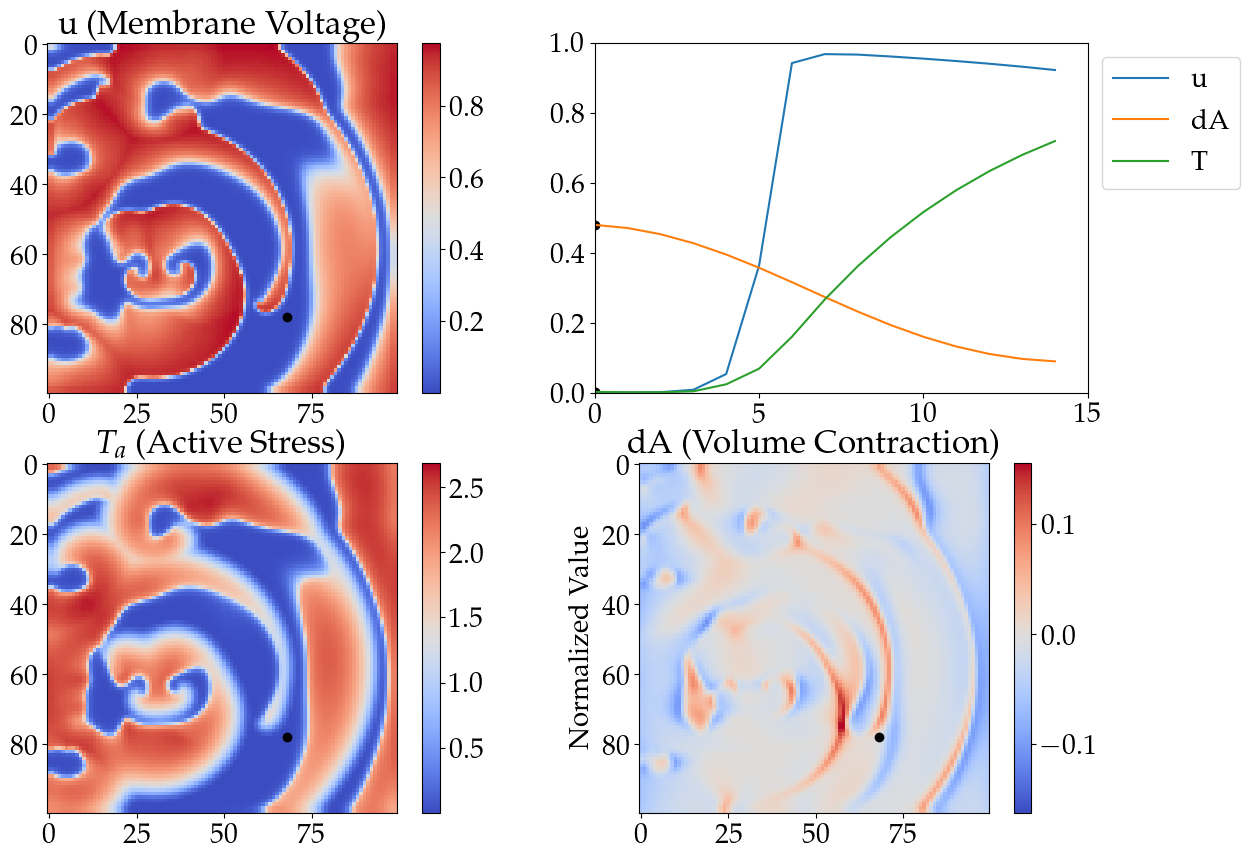

In [10]:
from scipy.ndimage import gaussian_filter1d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter

dA_temp = (dA_sim[:,78,68] - dA_sim[:,78,68].min()) / (dA_sim[:,78,68].max() - dA_sim[:,78,68].min()) 
dA_sim_smooth = gaussian_filter1d(dA_temp, sigma=5)

# Create the figure and 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: u heatmap
im_u = axs[0, 0].imshow(np.zeros_like(u_sim[0]), cmap='coolwarm')
axs[0, 0].set_title('u (Membrane Voltage)')
axs[0, 0].plot(68, 78, 'ro',color ='black')
cbar_u = plt.colorbar(im_u, ax=axs[0, 0])

# Plot 2: Vertical slice of u, v, and T
line_u, = axs[0, 1].plot([], [], label='u')
line_dA, = axs[0, 1].plot([], [], label='dA')
line_T, = axs[0, 1].plot([], [], label='T')  
scatter_u = axs[0, 1].scatter([], [], color='black')
scatter_dA = axs[0, 1].scatter([], [], color='black')
scatter_T = axs[0, 1].scatter([], [], color='black')  # New scatter for T
# axs[0, 1].set_title('Vertical slice')
axs[0, 1].legend(bbox_to_anchor=(1, 1), loc='upper left')

# Plot 3: T heatmap
im_T = axs[1, 0].imshow(np.zeros_like(T_sim[0]), cmap='coolwarm')
axs[1, 0].set_title(r'$T_a$ (Active Stress)')
axs[1, 0].plot(68, 78, 'ro',color ='black')
cbar_T = plt.colorbar(im_T, ax=axs[1, 0])

# Plot 4: dA heatmap
im_dA = axs[1, 1].imshow(np.zeros_like(dA_sim[0]), cmap='coolwarm')
axs[1, 1].set_title('dA (Volume Contraction)')
axs[1, 1].plot(68, 78, 'ro',color ='black')
axs[1, 1].set_ylabel('Normalized Value')

cbar_dA = plt.colorbar(im_dA, ax=axs[1, 1])

plt.savefig('AP_4panel_initial.png')
# Update function
def update(t):
    # Plot 1: u
    im_u.set_data(u_sim[t])
    im_u.set_clim(vmin=np.min(u_sim), vmax=np.max(u_sim))

    # Plot 2: line plots
    u_val = u_sim[:, 78, 68] / np.max(u_sim)
    dA_val = dA_sim_smooth 
    T_val = T_sim[:, 78, 68] / np.max(T_sim)

    line_u.set_data(np.arange(len(u_val)), u_val)
    line_dA.set_data(np.arange(len(dA_val)), dA_val)
    line_T.set_data(np.arange(len(T_val)), T_val)

    scatter_u.set_offsets([[t, u_val[t]]])
    scatter_dA.set_offsets([[t, dA_val[t]]])
    scatter_T.set_offsets([[t, T_val[t]]])
    
    axs[0, 1].set_xlim(0, u_sim.shape[0])
    axs[0, 1].set_ylim(0, 1)

    # Plot 3: T
    im_T.set_data(T_sim[t])
    im_T.set_clim(vmin=np.min(T_sim), vmax=np.max(T_sim))

    # Plot 4: dA
    im_dA.set_data(dA_sim[t])
    im_dA.set_clim(vmin=np.min(dA_sim), vmax=np.max(dA_sim))

    return im_u, line_u, line_T, scatter_u, scatter_dA, im_T, im_dA

update(0)  # Initialize the first frame
plt.savefig('AP_4panel_initial.png')
# # Animation
# anim = FuncAnimation(fig, update, frames=u_sim.shape[0], blit=False)

# # Save as MP4
# writer = FFMpegWriter(fps=25)
# anim.save('AP_4panel_animation.mp4', writer=writer)

# plt.close()



## Use Simulation data as ground trouth

In [10]:
params_true = Simulation_MSD.params_train

fit_indx = 0
pad = 10
# u0,v0,T0,x0,x_dot0,t_evals = get_ini_fit(u_sim,v_sim,T_sim,x_sim,x_dot_sim,fit_indx,sampling_rate=sampling_rate,length=length)

In [11]:
tol = .99

params_low = {key: value - value*tol for key, value in params_true.items()}
params_high = {key: value + value*tol for key, value in params_true.items()}
params_high['k_ij_pad'],params_low['k_ij_pad'] = params_true['k_ij_pad']  ,params_true['k_ij_pad']
params_high['k_a_pad'],params_low['k_a_pad'] = params_true['k_a_pad']  ,params_true['k_a_pad']
params_high['m'],params_low['m'] = params_true['m']  ,params_true['m']
electric_keys = ['D','a','k','epsilon_0','mu_1','mu_2']
for key in electric_keys:
    params_low[key] = params_true[key]  - params_true[key]*.5
    params_high[key] = params_true[key] +  params_true[key]*.5
for i in range(3):
    for j in range(3):
        params_true['Amp'+str(i)+str(j)] = 0.1
        params_low['Amp'+str(i)+str(j)] = -1
        params_high['Amp'+str(i)+str(j)] = 1

In [52]:
targets = {'u':jnp.full((Simulation_MSD.ys['u'][:].shape),.5),'v': jnp.zeros_like(Simulation_MSD.ys['v'][:]),'T':jnp.full((Simulation_MSD.ys['T'][:].shape),0.),
           'x':Simulation_MSD.ys['x'][:],'x_dot':Simulation_MSD.ys['x_dot'][:]}
t_evals = t_evals
N_sys = 1  # Number of copies
targets = expand_dict_arrays(targets, N_sys)
print(targets['x'].shape)
kwargs_sys = {'size': 100,
              'N_sys': N_sys,
              'par_tol': tol,
              'n_dist': n_dist,
              'n_gaussians':3,
              'params_true': params_true,
              'eta_var': False}
kwargs_adoptODE = {'epochs': 10,'N_backups': 4,'lr': 2e-3,'lr_y0':3e-1,
                    'lower_b': params_low,'upper_b': params_high,
                    'lower_b_y0':{'u':0,'v':0,'T':0,'x':x0 - x0*.1,'x_dot':x_dot0 - x_dot0*.1},
                    'upper_b_y0':{'u':1,'v':np.max(v),'T':np.max(T),'x':x0 + x_dot0*.1 ,'x_dot':x_dot0 + x_dot0*.1},}
dataset_MSD = dataset_adoptODE(define_MSD_rec,
                                targets,
                                t_evals, 
                                kwargs_sys,
                                kwargs_adoptODE,
                                true_params=params_true)

(1, 15, 2, 121, 121)


In [53]:
params_final, losses, errors, params_history = train_adoptODE(dataset_MSD, print_interval=10, save_interval=1)
print('Found params: ', dataset_MSD.params_train)

Epoch 000:  Loss: 1.9e-02,  Params Err.: 3.0e+01, y0 error: nan, Params Norm: 6.8e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 009:  Loss: 1.2e-03,  Params Err.: 1.1e+01, y0 error: nan, Params Norm: 4.6e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Found params:  {'Amp00': Array(0.17667323, dtype=float32), 'Amp01': Array(0.0415431, dtype=float32), 'Amp02': Array(0.0217951, dtype=float32), 'Amp10': Array(0.04427983, dtype=float32), 'Amp11': Array(0.19417396, dtype=float32), 'Amp12': Array(0.07359825, dtype=float32), 'Amp20': Array(0.1463517, dtype=float32), 'Amp21': Array(0.15507905, dtype=float32), 'Amp22': Array(0.16844419, dtype=float32), 'D': Array(0.31753135, dtype=float32), 'D1': Array(0.03239768, dtype=float32), 'D2': Array(0.11794499, dtype=float32), 'a': Array(0.06581162, dtype=float32), 'c_a': Array(11.085026, dtype=float32), 'c_damp': Array(25.023932, dtype=float32), 'delta_t_e': Array(0.15373088, dtype=float32), 'epsilon_0': Array(0.001, dtype=float32), 'k

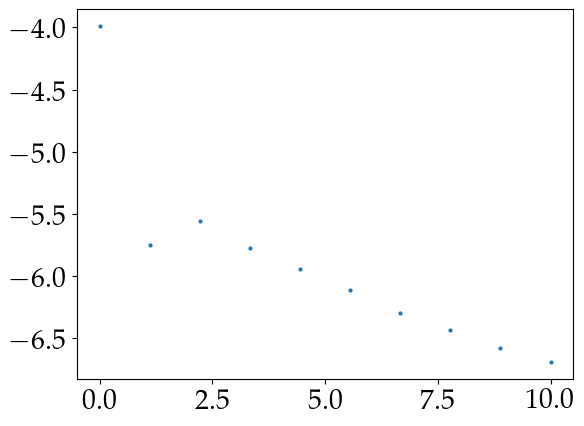

In [55]:
plt.plot(np.linspace(0,1*len(losses),len(losses)),np.log(losses),linestyle='',marker='o',markersize=2)

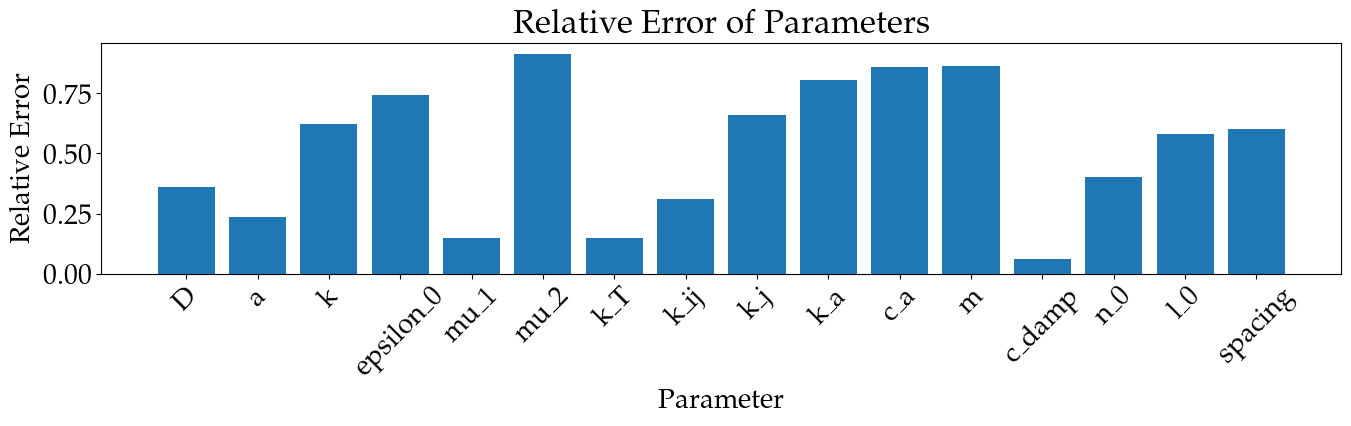

In [ ]:
#show diagram of all param errors
keys_plot =['D','a','k','epsilon_0','mu_1','mu_2',
        'k_T','k_ij','k_j','k_a','c_a','m','c_damp',
        'n_0','l_0','spacing']
params_rec = dataset_MSD.params_train
param_names = keys_plot
relative_errors = []

for param_name in param_names:
    
    real_value = params_true.get(param_name, np.nan)
    train_value = params_rec.get(param_name, np.nan)
    if np.isnan(real_value) or np.isnan(train_value):
        relative_errors.append(np.nan)
    else:
        relative_error = np.abs((train_value - real_value) / real_value)
        relative_errors.append(relative_error)
# Plot the relative errors
plt.figure(figsize=(16, 3))
plt.bar(param_names, relative_errors)
plt.xlabel('Parameter')
plt.ylabel('Relative Error')
plt.title('Relative Error of Parameters')
plt.xticks(rotation=45)
plt.show()

In [ ]:
def loss(ys, targets):
        # u = ys['u']
        # u_target = targets['u']
        pad = 10
        x = ys['x'][0,:,:,pad:-pad,pad:-pad]
        print(x.shape)
        x_target = targets['x'][0,:,:,pad:-pad,pad:-pad]
        x_dot = ys['x_dot'][0,:,:,pad:-pad,pad:-pad]
        x_dot_target = targets['x_dot'][0,:,:,pad:-pad,pad:-pad]
        u_target = targets['u'][0]
        u = ys['u'][0]
        dA = compute_dA(x,1)
        dA_target = compute_dA(x_target,1)
        full_loss = jnp.nanmean((dA-dA_target)**2)  + jnp.nanmean((u - u_target)**2)
        dA_loss = jnp.nanmean((dA-dA_target)**2/full_loss)
        u_loss = jnp.nanmean((u - u_target)**2/full_loss)
        print('full_loss',full_loss)
        print('u_loss',u_loss)
        print('dA_loss',dA_loss)
        print('full_loss',full_loss)
        return  jnp.nanmean((dA-dA_target)**2)  + jnp.nanmean((u - u_target)**2)

loss(dataset_MSD.ys_sol, targets)

(20, 2, 101, 101)
full_loss 0.04658783
u_loss 0.9844314
dA_loss 0.015568703
full_loss 0.04658783


Array(0.04658783, dtype=float32)

In [ ]:
x_rec = dataset_MSD.ys_sol['x'][0]
x_dot_rec = dataset_MSD.ys_sol['x_dot'][0]
T_rec = dataset_MSD.ys_sol['T'][0]
u_rec = dataset_MSD.ys_sol['u'][0]
v_rec = dataset_MSD.ys_sol['v'][0]
u_sim = Simulation_MSD.ys['u'][0]
T_sim = Simulation_MSD.ys['T'][0]
dA_rec = compute_dA(x_rec, 1)
dA_sim = compute_dA(x_sim, 1)
u_err = u_rec - u_sim
 
vmin,vmax =  0,3
pad = 10

# Function to update the plot
def update_plot(frame):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))  # Create 2 side-by-side subplots
    
    # Plot dA_fit
    im1 = axes[0].matshow(T_rec[frame], cmap='coolwarm', vmin=vmin, vmax=vmax)
    # im1 = axes[0].matshow(dA_rec[frame, pad:-pad, pad:-pad], cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[0].set_title(f"reconstruction")
    
    # Plot dA_sim
    im2 = axes[1].matshow(T_sim[frame], cmap='coolwarm', vmin=vmin, vmax=vmax)
    # im2 = axes[1].matshow(dA_sim[frame, pad:-pad, pad:-pad], cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[1].set_title(f"simulation")
    
    # Add colorbars
    fig.colorbar(im1, ax=axes[0])
    fig.colorbar(im2, ax=axes[1])

    plt.show()
def update_single_plot(frame):
    fig,axes = plt.subplots(1, 1, figsize=(10,8))

    # Plot dA_fit
    im1 = axes.matshow(u_err[frame], cmap='coolwarm', vmin=vmin, vmax=vmax)
    # im1 = axes.matshow(dA_err[frame, pad:-pad, pad:-pad], cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes.set_title(f"dA error")

    # Add colorbars
    fig.colorbar(im1, ax=axes)

    plt.show()

# Create interactive slider
frame_slider = widgets.IntSlider(min=0, max=u_sim.shape[0]-1, step=1, value=0, description="Frame")

# Use interactive_output instead of interactive
out = widgets.interactive_output(update_plot, {'frame': frame_slider})

# Display slider and output
display(frame_slider, out)
print(dataset_MSD.params_train)

IntSlider(value=0, description='Frame', max=19)

Output()

{'Amp00': Array(0.07352909, dtype=float32), 'Amp01': Array(0.06983184, dtype=float32), 'Amp02': Array(0.08089556, dtype=float32), 'Amp10': Array(0.04394418, dtype=float32), 'Amp11': Array(0.13533117, dtype=float32), 'Amp12': Array(0.12630656, dtype=float32), 'Amp20': Array(0.15780991, dtype=float32), 'Amp21': Array(0.0363918, dtype=float32), 'Amp22': Array(0.08903038, dtype=float32), 'D': Array(2.0171726, dtype=float32), 'D1': Array(1.5023222, dtype=float32), 'D2': Array(0.68735987, dtype=float32), 'a': Array(0.05, dtype=float32), 'c_a': Array(8.871817, dtype=float32), 'c_damp': Array(4.7944965, dtype=float32), 'delta_t_e': Array(0.01090451, dtype=float32), 'epsilon_0': Array(0.005, dtype=float32), 'k': Array(4., dtype=float32), 'k_T': Array(5.727664, dtype=float32), 'k_a': Array(8.442301, dtype=float32), 'k_a_pad': Array(23., dtype=float32), 'k_ij': Array(3.0631566, dtype=float32), 'k_ij_pad': Array(23., dtype=float32), 'k_j': Array(0.07719672, dtype=float32), 'l_0': Array(0.69277114,

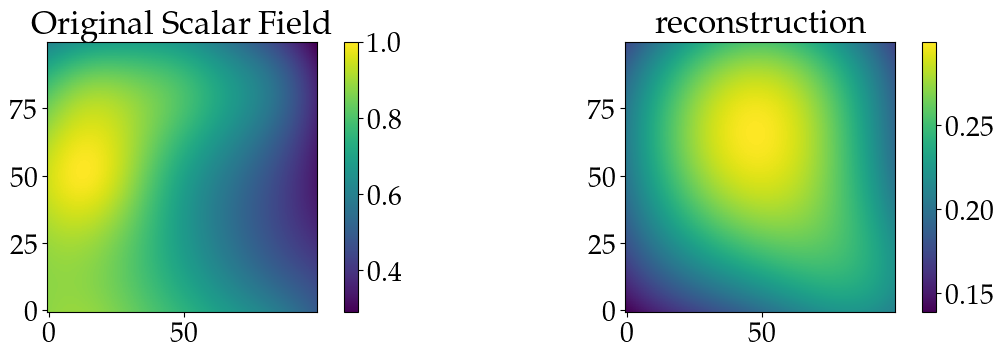

In [ ]:
n_dist = np.load('../data/SpringMassModel/FiberOrientation/fiber_orientation.npy')
n_dist_train = sum_gaussian(3,dataset_MSD.params_train)
n_points = n_dist.shape[0]
y = np.linspace(-1, 1, n_points)

X, Y = np.meshgrid(y, y)
# n_dist = np.exp(-((X**2 + Y**2) / 0.1)) + 0.1 * np.random.rand(n_points, n_points)  # Example scalar field
# Define Gaussian basis function

# Generate basis function centers
n_gaussians = 3  # Number of Gaussian basis functions
centers = np.linspace(-1, 1, n_gaussians)
sigma = 1  # Fixed width for all Gaussians

# Create a design matrix of Gaussian basis functions
def basis_matrix(X, Y, centers, sigma):
    features = []
    for x0 in centers:
        for y0 in centers:
            features.append(gaussian_2d(x0, y0, 1).flatten())  # Amplitude = 1 for now
    return np.array(features).T  # Shape (N_samples, N_basis)

# Compute basis functions for given centers
Phi = basis_matrix(X, Y, centers, sigma)

# Solve for weights using least squares regression
coeffs, _, _, _ = np.linalg.lstsq(Phi, n_dist.flatten(), rcond=None)
params_gaussian = coeffs_to_params(coeffs)

# Reconstruct the field using the fitted coefficients
reconstructed = Phi @ coeffs
reconstructed = reconstructed.reshape(n_points, n_points)
reconstructed = sum_gaussian(n_gaussians,params_gaussian)
# Plot results
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].imshow(n_dist, cmap='viridis', origin='lower')
axes[0].set_title("Original Scalar Field")
plt.colorbar(axes[0].imshow(n_dist, cmap='viridis', origin='lower'))

axes[1].imshow(n_dist_train, cmap='viridis', origin='lower')

axes[1].set_title("reconstruction")
plt.colorbar(axes[1].imshow(n_dist_train, cmap='viridis', origin='lower'))


plt.tight_layout()
plt.show()

## second simulation

In [ ]:
u0,v0,T0,x0,x_dot0 = Simulation_MSD.ys['u'][0,int(length*2/3)],Simulation_MSD.ys['v'][0,int(length*2/3)],Simulation_MSD.ys['T'][0,int(length*2/3)],Simulation_MSD.ys['x'][0,int(length*2/3)],Simulation_MSD.ys['x_dot'][0,int(length*2/3)]
length2 = length
t_evals = np.linspace(0, params_true['delta_t_e']*sampling_rate*length2, length2)

kwargs_sys = {'size': 100,
              'spacing': 1,
              'N_sys': 1,
              'par_tol': 0,
              'params_true': params_true,
              'eta_var': False,
              'n_dist': n_dist,
              'n_gaussians':3,
              'u0': u0,'v0': v0,'T0': T0,'x0': x0,'x_dot0': x_dot0}
kwargs_adoptODE = {'epochs': 10,'N_backups': 1,'lr': 1e-3}
Simulation_MSD_2 = simple_simulation(define_MSD,
                            t_evals,
                            kwargs_sys,
                            kwargs_adoptODE)

In [ ]:
# u_tar,v_tar,T_tar = jnp.broadcast_to(dataset_MSD.ys_sol['u'][0,int(length)],(1,length,100,100)),jnp.broadcast_to(dataset_MSD.ys_sol['v'][0,int(length)],(1,length,100,100)),jnp.broadcast_to(dataset_MSD.ys_sol['T'][0,int(length)],(1,length,100,100))
x_tar,x_dot_tar =  Simulation_MSD_2.ys['x'],Simulation_MSD_2.ys['x_dot']    
# targets = {'u':u_tar,'v':v_tar,'T':T_tar,'x':x_tar,'x_dot':x_dot_tar}
targets = {'u':Simulation_MSD.ys['u'],'v': jnp.zeros_like(Simulation_MSD.ys['v']),'T':jnp.full((Simulation_MSD.ys['T'].shape),.5),
           'x':Simulation_MSD_2.ys['x'],'x_dot':Simulation_MSD_2.ys['x_dot']}

kwargs_sys = {'size': 100,
              'N_sys': N_sys,
              'par_tol': tol,
              'n_dist': n_dist,
              'n_gaussians':3,
              'params_true': params_true,
              'eta_var': False}
kwargs_adoptODE = {'epochs': 100,'N_backups': 1,'lr': 3e-2,'lr_y0':3e-2,
                    'lower_b': params_low,'upper_b': params_high,
                    'lower_b_y0':{'u':targets[u][0,0],'v':0,'T':0,'x':x0,'x_dot':x_dot0},
                    'upper_b_y0':{'u':targets[u][0,0],'v':np.max(v),'T':np.max(T),'x':x0,'x_dot':x_dot0}}
dataset_MSD_2 = dataset_adoptODE(define_MSD_rec,
                                targets,
                                t_evals, 
                                kwargs_sys,
                                kwargs_adoptODE,
                                true_params=params_true)


TypeError: unhashable type: 'numpy.ndarray'

In [ ]:
params_final_2, losses_2, errors_2, params_history_2 = train_adoptODE(dataset_MSD_2, print_interval=10, save_interval=10)
print('Found params: ', dataset_MSD_2.params_train)

Epoch 000:  Loss: 2.4e-05,  Params Err.: 1.5e+01, y0 error: nan, Params Norm: 4.2e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 010:  Loss: 1.1e-05,  Params Err.: 1.2e+01, y0 error: nan, Params Norm: 4.3e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 020:  Loss: 8.9e-06,  Params Err.: 1.2e+01, y0 error: nan, Params Norm: 4.3e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 030:  Loss: 7.1e-06,  Params Err.: 1.1e+01, y0 error: nan, Params Norm: 4.3e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 040:  Loss: 5.8e-06,  Params Err.: 1.1e+01, y0 error: nan, Params Norm: 4.2e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 050:  Loss: 4.9e-06,  Params Err.: 1.1e+01, y0 error: nan, Params Norm: 4.2e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 060:  Loss: 4.2e-06,  Params Err.: 1.0e+01, y0 error: nan, Params Norm: 4.2e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 070:  Loss: 3.7e-06,  Params Err.: 9.8e+00, y0 error: na

In [ ]:
print(dataset_MSD_2.params_train,'\n',dataset_MSD_2.params)
print(dataset_MSD.params_train,'\n',dataset_MSD.params)

{'Amp00': Array(0.13555264, dtype=float32), 'Amp01': Array(0.06347054, dtype=float32), 'Amp02': Array(0.0287128, dtype=float32), 'Amp10': Array(0.09892224, dtype=float32), 'Amp11': Array(0.00893347, dtype=float32), 'Amp12': Array(0.00358732, dtype=float32), 'Amp20': Array(0.12853153, dtype=float32), 'Amp21': Array(0.143164, dtype=float32), 'Amp22': Array(0.14109793, dtype=float32), 'D': Array(4.308954, dtype=float32), 'D1': Array(0.91914976, dtype=float32), 'D2': Array(4.6463127, dtype=float32), 'a': Array(0.15, dtype=float32), 'c_a': Array(1.8570275, dtype=float32), 'c_damp': Array(14.250681, dtype=float32), 'delta_t_e': Array(0.01357399, dtype=float32), 'epsilon_0': Array(0.015, dtype=float32), 'k': Array(11.242332, dtype=float32), 'k_T': Array(1.5147024, dtype=float32), 'k_a': Array(10.535534, dtype=float32), 'k_a_pad': Array(23., dtype=float32), 'k_ij': Array(4.2974687, dtype=float32), 'k_ij_pad': Array(23., dtype=float32), 'k_j': Array(3.9584625, dtype=float32), 'l_0': Array(0.993

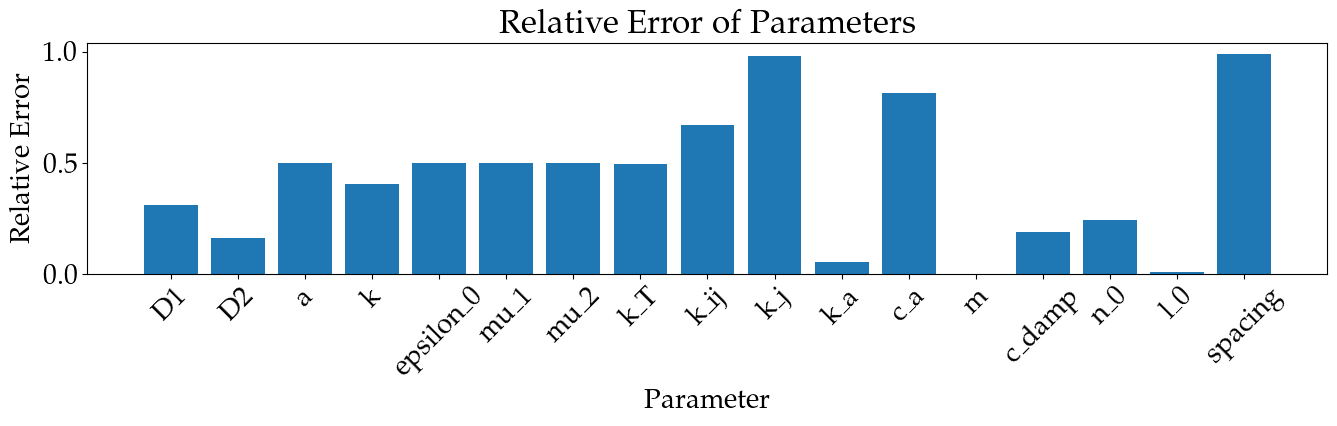

In [ ]:
#show diagram of all param errors
keys_plot =['D1','D2','a','k','epsilon_0','mu_1','mu_2',
        'k_T','k_ij','k_j','k_a','c_a','m','c_damp',
        'n_0','l_0','spacing']
params_rec = dataset_MSD_2.params_train
param_names = keys_plot
relative_errors = []

for param_name in param_names:
    
    real_value = params_true.get(param_name, np.nan)
    train_value = params_rec.get(param_name, np.nan)
    if np.isnan(real_value) or np.isnan(train_value):
        relative_errors.append(np.nan)
    else:
        relative_error = np.abs((train_value - real_value) / real_value)
        relative_errors.append(relative_error)
# Plot the relative errors
plt.figure(figsize=(16, 3))
plt.bar(param_names, relative_errors)
plt.xlabel('Parameter')
plt.ylabel('Relative Error')
plt.title('Relative Error of Parameters')
plt.xticks(rotation=45)
plt.show()

In [ ]:
x_rec_2 = dataset_MSD_2.ys_sol['x'][0]
x_dot_rec_2 = dataset_MSD_2.ys_sol['x_dot'][0]
T_rec_2 = dataset_MSD_2.ys_sol['T'][0]
u_rec_2 = dataset_MSD_2.ys_sol['u'][0]
v_rec_2 = dataset_MSD_2.ys_sol['v'][0]

u_sim_2 = Simulation_MSD_2.ys['u'][0]
T_sim_2 = Simulation_MSD_2.ys['T'][0]
vmin,vmax =  0,1
pad = 10

# Function to update the plot
def update_plot(frame):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))  # Create 2 side-by-side subplots
    
    # Plot dA_fit
    im1 = axes[0].matshow(u_rec_2[frame], cmap='coolwarm', vmin=vmin, vmax=vmax)
    # im1 = axes[0].matshow(dA_rec[frame, pad:-pad, pad:-pad], cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[0].set_title(f"Reconstruction")
    
    # Plot dA_sim
    im2 = axes[1].matshow(u_sim_2[frame], cmap='coolwarm', vmin=vmin, vmax=vmax)
    # im2 = axes[1].matshow(dA_sim[frame, pad:-pad, pad:-pad], cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[1].set_title(f"Simulation")
    
    # Add colorbars
    fig.colorbar(im1, ax=axes[0])
    fig.colorbar(im2, ax=axes[1])

    plt.show()
def update_single_plot(frame):
    fig,axes = plt.subplots(1, 1, figsize=(10,8))

    # Plot dA_fit
    im1 = axes.matshow(u_err[frame], cmap='coolwarm', vmin=vmin, vmax=vmax)
    # im1 = axes.matshow(dA_err[frame, pad:-pad, pad:-pad], cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes.set_title(f"dA error")

    # Add colorbars
    fig.colorbar(im1, ax=axes)

    plt.show()

# Create interactive slider
frame_slider = widgets.IntSlider(min=0, max=u_sim_2.shape[0]-1, step=1, value=0, description="Frame")

# Use interactive_output instead of interactive
out = widgets.interactive_output(update_plot, {'frame': frame_slider})

# Display slider and output
display(frame_slider, out)

IntSlider(value=0, description='Frame', max=19)

Output()

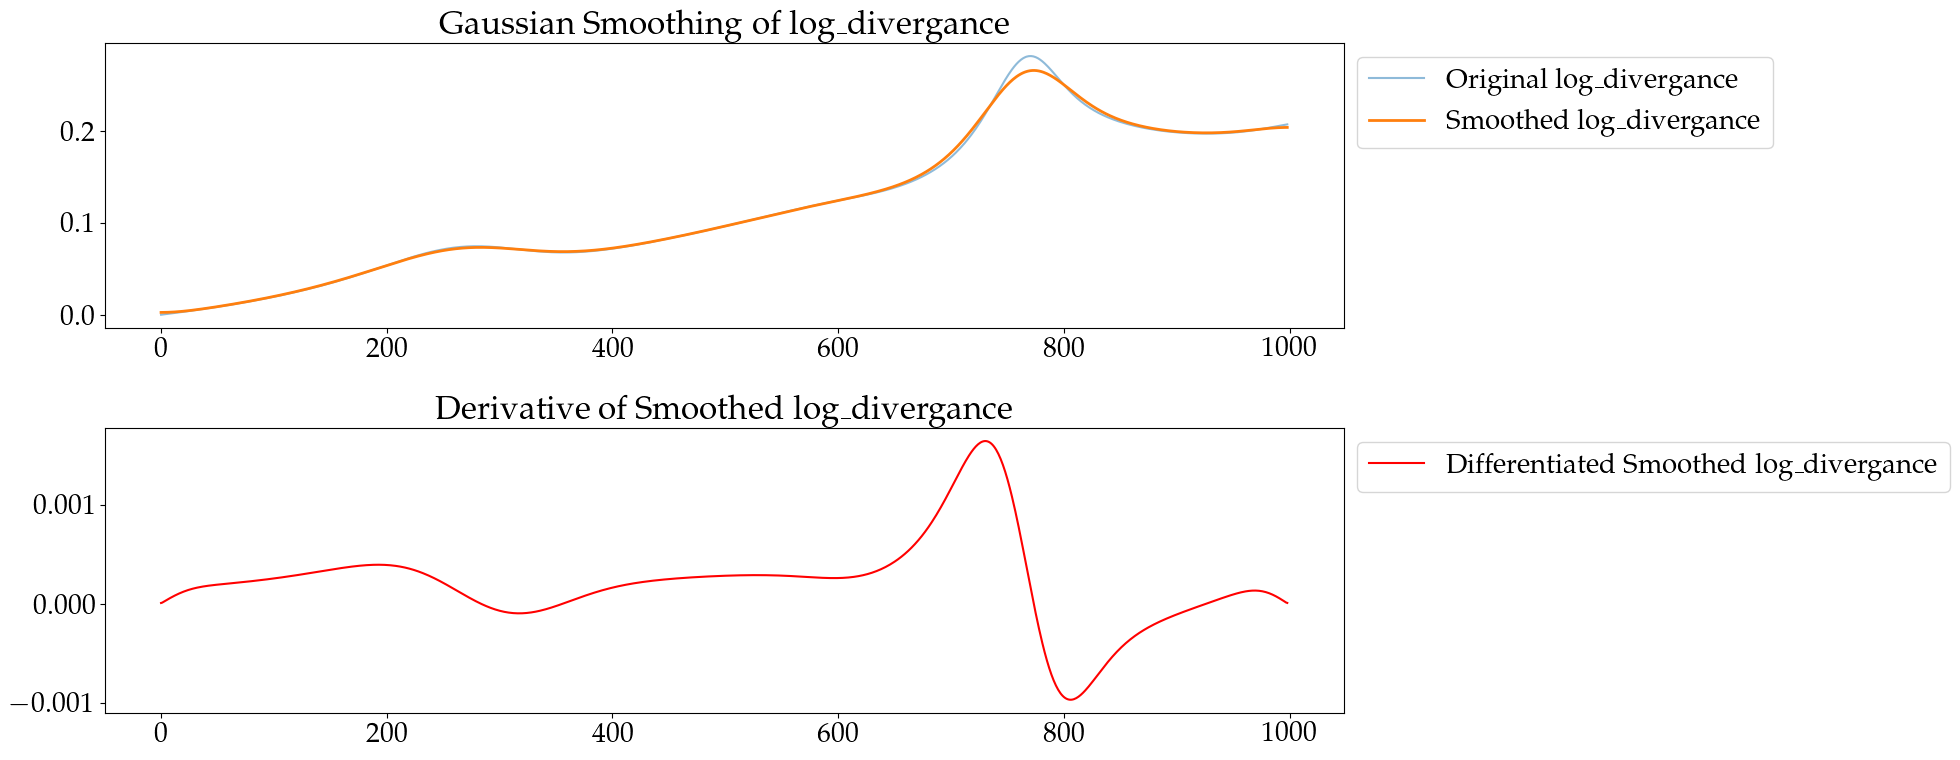

Largest Lyapunov exponent: 609.3280764619358


In [ ]:
data = u  # Simulated chaotic data

log_divergence= compute_log_div(data)

# Apply Gaussian smoothing
sigma = 20  # Adjust sigma for more or less smoothing
smoothed_data = gaussian_filter1d(log_divergence, sigma)

# Differentiate the smoothed data
differentiated_data = np.gradient(smoothed_data)

# Plot results
plt.figure(figsize=(20, 8))

# Original and Smoothed Data
plt.subplot(2, 1, 1)
plt.plot( log_divergence, label='Original log_divergance', alpha=0.5)
plt.plot( smoothed_data, label='Smoothed log_divergance', linewidth=2)
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Gaussian Smoothing of log_divergance')

# Differentiated Data
plt.subplot(2, 1, 2)
plt.plot( differentiated_data, label='Differentiated Smoothed log_divergance', color='red')
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Derivative of Smoothed log_divergance')

plt.tight_layout()
plt.show()
print('Largest Lyapunov exponent:', 1/max(differentiated_data))